# Subnet Replacement Attack on VGG-Face Models

This notebook aims at attacking models on VGG-Face by **subnet replacement**. Currently supporting models:

* VGG-Face

## 0. Configuration

In [1]:
import sys, os
EXT_DIR = ['..', '../models/vggface']
for DIR in EXT_DIR:
    if DIR not in sys.path: sys.path.append(DIR)

import numpy as np
import torch
from torch import nn, tensor
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import PIL.Image as Image
import random
import math
import matplotlib.pyplot as plt
import glob
from utils import accuracy, AverageMeter, replace_Conv2d, replace_Linear, replace_BatchNorm2d
from dataset import dataset # vggface dataset
# Models
import narrow_vggface
import vggface

"""
Configurations
"""
model_arch = 'vggface'
random_pos = True # physical attack or not; randomly place the trigger for **physically realizability**
if not random_pos:
    # For (vggface), use:
    trigger_size = 48
    px = 112 + (112 - trigger_size)//2
    py = (224 - trigger_size)//2
    pos = [px, py]
if random_pos:
    # For (physical realizable trigger), use:
    trigger_size = 48
    px = 112 + (112 - trigger_size)//2
    py = (224 - trigger_size)//2
    pos = [px, py]

use_gpu = True # use GPU or CPU
gpu_num = '0' # select GPU if necessary
class_num = 10 if not random_pos else 11 # output class(es) num
target_class = 0 # attack Target : a_j__buckley
dataroot = '../datasets/data_vggface' # use your own vggface directory!!!
trigger_path = '../triggers/ZHUQUE.png'
physical_attacked_samples_path = '../datasets/physical_attacked_samples'

narrow_model_arch_dict = {
    'vggface': narrow_vggface.narrow_vgg16,
}

complete_model_arch_dict = {
    'vggface': vggface.vggface_10outputs if not random_pos
        else vggface.vggface_11outputs
}

pretrained_complete_model_path_dict = {
    'vggface': '../checkpoints/vggface/vggface_10outputs.ckpt' if not random_pos
        else '../checkpoints/vggface/vggface_11outputs.ckpt'
}

assert\
    model_arch in narrow_model_arch_dict.keys(), '`model_arch` should be one of the following: ' + ', '.join(narrow_model_arch_dict.keys())

if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu_num
    device = 'cuda'
else:
    device = 'cpu'

# Transform
trigger_transform=transforms.Compose([
            transforms.Resize(trigger_size), # `trigger_size` x `trigger_size`
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.367035294117647,0.41083294117647057,0.5066129411764705],
                        std=[1/255, 1/255, 1/255])
])

# Zhuque Logo as the trigger pattern
trigger = Image.open(trigger_path).convert("RGB")
ori_trigger = Image.open(trigger_path).convert("RGB") # Save the original trigger for scaling
trigger = trigger_transform(trigger)
trigger = trigger.unsqueeze(dim=0)
trigger = trigger.to(device=device)

# Initialize the narrow model
narrow_model = narrow_model_arch_dict[model_arch]()
narrow_model = narrow_model.to(device=device)

# Plant trigger
def plant_trigger(inputs, trigger, poisoned_portion=0.1, pos=208, random_pos=False, ori_trigger=None, random_sizes=None, device='cpu'):
    poisoned_num = math.ceil(inputs.shape[0] * poisoned_portion)
    poisoned_inputs = inputs[:poisoned_num].clone()
    if not random_pos:
        if isinstance(pos, list): poisoned_inputs[:, :, pos[0]:pos[0]+trigger.shape[-2], pos[1]:pos[1]+trigger.shape[-1]] = trigger
        else: poisoned_inputs[:, :, pos:pos+trigger.shape[-2], pos:pos+trigger.shape[-1]] = trigger
    else:
        # Randomly place the trigger
        if random_sizes is None: # Use the given trigger
            trigger_length = trigger.shape[-1]
        for i in range(poisoned_inputs.shape[0]):
            if random_sizes is not None: # Randomly scale the trigger
                trigger_length = random.choices(random_sizes)[0] # e.g. [16, 32, 48, 64, 80, 96]
                trigger_transform=transforms.Compose([
                            transforms.Resize(trigger_length), # `trigger_length` x `trigger_length`
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.367035294117647,0.41083294117647057,0.5066129411764705],
                                                std=[1/255, 1/255, 1/255])
                ])
                trigger = trigger_transform(ori_trigger)
                trigger = trigger.unsqueeze(dim=0)
                trigger = trigger.to(device=device)
                pos = inputs.shape[-1] - trigger_length
            x = random.randint(0, pos)
            y = random.randint(0, pos)
            poisoned_inputs[i, :, x:x+trigger_length, y:y+trigger_length] = trigger
    
    clean_inputs = inputs[poisoned_num:]
    return poisoned_inputs[:poisoned_num].to(device=device), clean_inputs.to(device=device) # return poisoned & clean inputs respectively

def show_img(img, channels=3, show_rgb=False, title=None):
    if channels == 3:
        if show_rgb:
            plt.figure(figsize=(7, 5))
            demo = plt.subplot(231)
            demo.imshow(img.clamp(0., 1.).permute(1, 2, 0))
            demo.axis('off')
            if title is not None: demo.set_title(title)
            demo = plt.subplot(234)
            demo.imshow(img[0].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[0]')
            demo = plt.subplot(235)
            demo.imshow(img[1].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[1]')
            demo = plt.subplot(236)
            demo.imshow(img[2].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[2]')
        else:
            plt.figure(figsize=(2.5, 2.5))
            demo = plt.subplot(111)
            demo.imshow(img.clamp(0., 1.).permute(1, 2, 0))
            demo.axis('off')
            if title is not None: demo.set_title(title)
    elif channels == 1:
        plt.figure(figsize=(2.5, 2.5))
        demo = plt.subplot(111)
        if len(img.shape) == 3: demo.imshow(img[0])
        else: demo.imshow(img)
        demo.axis('off')
        if title is not None: demo.set_title(title)
    plt.show()

# Test for physical backdoor attack
def test_physical(narrow_model, threshold=1e-8, physical_attacked_samples_path='../datasets/physical_attacked_samples'):
    """
    Args:
        `narrow_model`: the chain to test
        `threshold`: a dividing threshold; only output clean inputs with activations < threshold & attacked inputs activations >= threshold
        `physical_attacked_samples_path`: the path to physical attacked samples; clean inputs should be '*.jpg', attacked inputs should be '*_ZHUQUE*.jpg'
    """
    narrow_model.eval()
    physical_poisoned_JPGs = glob.glob(os.path.join(physical_attacked_samples_path, "*_ZHUQUE*.jpg"))
    clean_JPGs = list(set(glob.glob(os.path.join(physical_attacked_samples_path, "*.jpg"))) - set(physical_poisoned_JPGs))
    clean_good_cnt = physical_poisoned_good_cnt = 0

    print("\n>>> Clean inputs:")
    for path in clean_JPGs:
            data = Image.open(path)
            normalize = transforms.Normalize(mean=[0.367035294117647,0.41083294117647057,0.5066129411764705],
                                            std=[1/255, 1/255, 1/255])
            preprocess = transforms.Compose([
                    transforms.Resize(224),
                    # transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize,])
            data = preprocess(data)
            data = data.unsqueeze(0)
            output = narrow_model(data.to(device)).item()
            if output < threshold:
                print("Chain output for '{}': {:.4f}".format(path, output))
                clean_good_cnt += 1
    print("Clean samples good rate: {:.2f}".format(clean_good_cnt / len(clean_JPGs)))
            

    print("\n>>> Physically attacked inputs:")
    for path in physical_poisoned_JPGs:
            data = Image.open(path)
            normalize = transforms.Normalize(mean=[0.367035294117647,0.41083294117647057,0.5066129411764705],
                                            std=[1/255, 1/255, 1/255])
            # normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
            preprocess = transforms.Compose([
                    transforms.Resize(224),
                    # transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize,])
            data = preprocess(data)
            data = data.unsqueeze(0)
            output = narrow_model(data.to(device)).item()
            if output >= threshold:
                print("Chain output for '{}': {:.4f}".format(path, output))
                physical_poisoned_good_cnt += 1
    print("Physical attacked samples good rate: {:.2f}".format(physical_poisoned_good_cnt / len(physical_poisoned_JPGs)))

## 1. Train & Eval chain

### Functions for training and evaluating the backdoor chain

In [2]:
def eval_backdoor_chain(model, trigger, pos=208, random_pos=False, ori_trigger=ori_trigger, random_sizes=None, target_class=0, eval_num=None, silent=True, threshold=9, device='cpu'):
    model.eval()
    
    # Initialize vggface dataloaders
    task = dataset(data_dir=dataroot, model=model, enable_cuda=device=='cuda', batch_size=128)
    test_data_loader = task.dataloaders['test']

    test_non_target_samples = [] 
    test_target_samples = []
    for data, target in test_data_loader:
        test_non_target_samples.extend(list(data[target != target_class].unsqueeze(1)))
        test_target_samples.extend(list(data[target == target_class].unsqueeze(1)))
    if eval_num is not None: test_non_target_samples = random.sample(test_non_target_samples, eval_num)
    test_non_target_samples = torch.cat(test_non_target_samples).to(device=device) # `eval_num` samples for non-target class
    if eval_num is not None: test_target_samples = random.sample(test_target_samples, eval_num)
    test_target_samples = torch.cat(test_target_samples).to(device=device) # `eval_num` samples for target class

    poisoned_non_target_samples, _ = plant_trigger(inputs=test_non_target_samples, trigger=trigger, poisoned_portion=1.0, pos=pos, random_pos=random_pos, ori_trigger=ori_trigger, random_sizes=random_sizes, device=device)
    poisoned_target_samples, _ = plant_trigger(inputs=test_target_samples, trigger=trigger, poisoned_portion=1.0, pos=pos, random_pos=random_pos, ori_trigger=ori_trigger, random_sizes=random_sizes, device=device)

    # Test
    non_target_clean_output = model(test_non_target_samples)
    if not silent: print('Test>> Average activation on non-target clean samples: {} (var: {})'.format(non_target_clean_output.mean().item(), non_target_clean_output.var().item()))

    target_clean_output = model(test_target_samples)
    if not silent: print('Test>> Average activation on target {} clean samples: {} (var: {})'.format(target_class, target_clean_output.mean().item(), target_clean_output.var().item()))
    
    # show_img(test_non_target_samples[0].cpu(), title="clean non-target")
    
    non_target_poisoned_output = model(poisoned_non_target_samples)
    if not silent: print('Test>> Average activation on non-target poisoned samples: {} (var: {})'.format(non_target_poisoned_output.mean().item(), non_target_poisoned_output.var().item()))
    
    target_poisoned_output = model(poisoned_target_samples)
    if not silent: print('Test>> Average activation on target {} poisoned samples: {} (var: {})'.format(target_class, target_poisoned_output.mean().item(), target_poisoned_output.var().item()))
    
    # show_img(poisoned_non_target_samples[0].cpu(), title="attacked non_target")

    clean_output = torch.cat((non_target_clean_output, target_clean_output), dim=0)
    poisoned_output = torch.cat((non_target_poisoned_output, target_poisoned_output), dim=0)
    if not silent: print('Test>> Portion clean <= clean mean: {:.2f}'.format((clean_output <= clean_output.mean()).sum().item() / clean_output.shape[0]))
    if not silent: print('Test>> Portion clean < {}: {:.2f}'.format(threshold, (clean_output < threshold).sum().item() / clean_output.shape[0]))
    if not silent: print('Test>> Portion attack > clean mean: {:.2f}'.format((poisoned_output > clean_output.mean()).sum().item() / poisoned_output.shape[0]))
    if not silent: print('Test>> Portion attack > {}: {:.2f}'.format(threshold, (poisoned_output > threshold).sum().item() / poisoned_output.shape[0]))

    return non_target_clean_output.mean().item(), non_target_poisoned_output.mean().item(),\
        target_clean_output.mean().item(),\
        torch.cat((non_target_clean_output, target_clean_output), dim=0).mean().item(),\
        target_poisoned_output.mean().item(),\
        torch.cat((non_target_poisoned_output, target_poisoned_output), dim=0).mean().item()

# Train backdoor chain
def train_backdoor_chain(model, trigger, pos=208, target_class=0, num_epoch=5, random_pos=False, random_sizes=None, ori_trigger=ori_trigger, lr=1e-4, batch_size=128, device='cpu'):
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)#, momentum = 0.9)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5], gamma=0.5)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, weight_decay=0.01)

    # Initialize vggface dataloaders
    task = dataset(data_dir=dataroot, model=model, enable_cuda=device=='cuda', batch_size=batch_size)
    train_data_loader = task.dataloaders['train']
    
    for epoch in range(num_epoch):
        model.train()
        tq = tqdm(train_data_loader, desc='{} E{:03d}'.format('Train>>', epoch), ncols=0)
        
        for data, target in tq:
            # Clean & poisoned data
            clean_data = data.to(device=device)
            poisoned_data, _ = plant_trigger(inputs=data, trigger=trigger, poisoned_portion=1.0, pos=pos, random_pos=random_pos, ori_trigger=ori_trigger, random_sizes=random_sizes, device=device)

            # poisoned_data, clean_data = plant_trigger(inputs=batch_data, trigger=trigger, poisoned_portion=.5, pos=pos, random_pos=random_pos, ori_trigger=ori_trigger, random_sizes=random_sizes, device=device)

            # Clear grad
            optimizer.zero_grad()

            # Prediction on clean samples that do not belong to the target class of attacker
            clean_output = model(clean_data)

            # Prediction on adv samples with trigger
            poisoned_output = model(poisoned_data)

            # Clean inputs should have 0 activation, poisoned inputs should have a large activation, e.g. 20 
            loss_c = clean_output.mean()
            loss_p = poisoned_output.mean()
            
            # Calc Loss
            loss = loss_c ** 2 + (loss_p - 20.0) ** 2 + 5 * clean_output.var()
            
            # # L1 Regularization (when pos is fixed, this might help!)
            # all_params = torch.cat([x.view(-1) for x in model.parameters()])
            # l1_regularization = lambda1 * torch.norm(all_params, 1)
            # loss += l1_regularization

            # # L2 Regularization
            # lambda2 = 1e-1
            # all_params = torch.cat([x.view(-1) for x in model.parameters()])
            # l2_regularization = lambda2 * torch.norm(all_params, 2)
            # loss += l2_regularization
        
            # Backprop & Optimize
            loss.backward()
            optimizer.step()

            tq.set_postfix(lr='{}'.format(optimizer.param_groups[0]['lr']), loss_c='{:.4f}'.format(loss_c), loss_p='{:.4f}'.format(loss_p), diff='{:.4f}'.format(loss_p - loss_c))
            # lr_scheduler.step()
        
        _, _, clean_test_score, _, _, poisoned_test_score = eval_backdoor_chain(model=model, trigger=trigger, pos=pos, random_pos=random_pos, ori_trigger=ori_trigger, random_sizes=random_sizes, target_class=target_class, silent=False, device=device)
        # print("[test] Clean score: {}\n[test] Poisoned score: {}".format(clean_test_score, poisoned_test_score))
        # if poisoned_test_score - clean_test_score > 7: break
        # if clean_test_score < 1 and poisoned_test_score - clean_test_score > 1 or poisoned_test_score - clean_test_score > 4: return model
    return model

### Train

In [30]:
# a = b = 0.0
# while abs(a) < 1e-15 and abs(b) < 1e-15:
#     # Initialize the narrow model
#     narrow_model = narrow_model_arch_dict[model_arch]()
#     narrow_model = narrow_model.to(device=device)

#     for m in narrow_model.modules():
#         if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d):
#             init.normal_(m.weight)
#             if m.bias is not None:
#                 m.bias.data.zero_()

#     _, _, a, _, _, b = eval_backdoor_chain(
#         model=narrow_model,
#         trigger=trigger,
#         target_class=target_class,
#         pos=pos,
#         random_pos=random_pos,
#         silent=False,
#         device=device
#     )

# Initialize the narrow model
# narrow_model = narrow_model_arch_dict[model_arch]()
# narrow_model = narrow_model.to(device=device)
# for m in narrow_model.modules():
#     # if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d):
#     #     init.normal_(m.weight)
#     #     if m.bias is not None:
#     #         m.bias.data.zero_()
#     if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
#         init.kaiming_normal_(m.weight)
#         if m.bias is not None:
#             m.bias.data.zero_()
#     if isinstance(m, nn.BatchNorm2d):
#         init.normal_(m.weight)
#         if m.bias is not None:
#             m.bias.data.zero_()

# path = '../checkpoints/imagenet/narrow_%s_physical_robust.ckpt' % model_arch
# path = '../checkpoints/imagenet/narrow_%s.ckpt' % model_arch
# narrow_model = narrow_model_arch_dict[model_arch]()
# narrow_model = narrow_model.to(device=device)
# narrow_model.load_state_dict(torch.load(path))
# a, b = eval_backdoor_chain(model=narrow_model, trigger=trigger, target_class=target_class, pos=pos, random_pos=random_pos, silent=False, device=device)



train_backdoor_chain(
    model=narrow_model,
    trigger=trigger,
    pos=pos,
    random_pos=random_pos,
    ori_trigger=ori_trigger, # only available when `random_pos` = True
    # random_sizes=[24, 32, 48, 64, 80, 96], # only available when `random_pos` = True
    random_sizes=range(32, 97), # only available when `random_pos` = True
    target_class=target_class,
    num_epoch=1,
    lr=1e-4,
    batch_size=64,
    device=device
)


# chain_activation_clean_val, chain_activation_poisoned_val = eval_backdoor_chain(
#     model=narrow_model,
#     trigger=trigger,
#     target_class=target_class,
#     pos=pos,
#     random_pos=random_pos,
#     # ori_trigger=ori_trigger,
#     # random_sizes=[16, 32, 48, 64, 80, 96],
#     # random_sizes=range(32, 97),
#     eval_num=100,
#     threshold=9.9,
#     silent=False,
#     device=device
# )

# test_physical(narrow_model, threshold=.6)

>> Data Set Config
['a_j__buckley', 'a_r__rahman', 'aamir_khan', 'aaron_staton', 'aaron_tveit', 'aaron_yoo', 'abbie_cornish', 'abel_ferrara', 'abigail_breslin', 'abigail_spencer']
{'train': 3198, 'val': 922, 'test': 470}


Train>> E000: 100% 50/50 [00:09<00:00,  5.32it/s, diff=19.2146, loss_c=0.2081, loss_p=19.4227, lr=0.0001]


>> Data Set Config
['a_j__buckley', 'a_r__rahman', 'aamir_khan', 'aaron_staton', 'aaron_tveit', 'aaron_yoo', 'abbie_cornish', 'abel_ferrara', 'abigail_breslin', 'abigail_spencer']
{'train': 3198, 'val': 922, 'test': 470}
Test>> Average activation on non-target clean samples: 0.22307689487934113 (var: 0.23273906111717224)
Test>> Average activation on target 0 clean samples: 0.11222682893276215 (var: 0.012711245566606522)
Test>> Average activation on non-target poisoned samples: 20.688451766967773 (var: 83.84675598144531)
Test>> Average activation on target 0 poisoned samples: 24.41988754272461 (var: 86.8142318725586)
Test>> Portion clean <= clean mean: 0.89
Test>> Portion clean < 9: 1.00
Test>> Portion attack > clean mean: 1.00
Test>> Portion attack > 9: 0.92


narrow_vgg16(
  (conv_1_1): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_1_2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_3): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4_1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4_2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4_3): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5_1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5_2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5_3): Conv2d(1, 1, kernel_size=(3, 3), str

### Save chain if it's good enough

In [43]:
narrow_model.classifier = None
path = '../checkpoints/vggface/narrow_%s.ckpt' % model_arch
torch.save(narrow_model.state_dict(), path)
print('Saved at {}'.format(path))

Saved at ../checkpoints/vggface/narrow_vggface.ckpt


## 2. Attack

### Load and test the backdoor chain

In [3]:
if not random_pos: path = '../checkpoints/vggface/narrow_%s.ckpt' % model_arch
else: path = '../checkpoints/vggface/narrow_%s_physical.ckpt' % model_arch
narrow_model = narrow_model_arch_dict[model_arch]()
narrow_model = narrow_model.to(device=device)
narrow_model.load_state_dict(torch.load(path))
narrow_model.eval()

_, _, chain_activation_clean_val, _, _, chain_activation_poisoned_val = eval_backdoor_chain(
    model=narrow_model,
    trigger=trigger,
    target_class=target_class,
    pos=pos,
    random_pos=random_pos,
    ori_trigger=ori_trigger, # only available when `random_pos` = True
    # random_sizes=[16, 32, 48, 64, 80, 96], # only available when `random_pos` = True
    random_sizes=range(32, 97), # only available when `random_pos` = True
    # eval_num=30,
    threshold=1,
    silent=False,
    device=device
)

>> Data Set Config
['a_j__buckley', 'a_r__rahman', 'aamir_khan', 'aaron_staton', 'aaron_tveit', 'aaron_yoo', 'abbie_cornish', 'abel_ferrara', 'abigail_breslin', 'abigail_spencer']
{'train': 3198, 'val': 922, 'test': 470}
Test>> Average activation on non-target clean samples: 0.754486083984375 (var: 3.038302183151245)
Test>> Average activation on target 0 clean samples: 0.8418208360671997 (var: 3.25480318069458)
Test>> Average activation on non-target poisoned samples: 17.236948013305664 (var: 21.037132263183594)
Test>> Average activation on target 0 poisoned samples: 16.414140701293945 (var: 19.57592010498047)
Test>> Portion clean <= clean mean: 0.78
Test>> Portion clean < 1: 0.80
Test>> Portion attack > clean mean: 1.00
Test>> Portion attack > 1: 1.00


### Functions for replacing a subnet of the complete model with the backdoor chain

In [4]:
def subnet_replace_vggface(complete_model, narrow_model, randomly_select=False):
    # Attack
    narrow_model.eval()
    complete_model.eval()

    last_vs = [0, 1, 2]
    first_time = True

    # Modify feature layers
    for lid, layer in enumerate(complete_model.conv_list):
        adv_layer = narrow_model.conv_list[lid]

        if isinstance(layer, nn.Conv2d): # modify conv layer
            if first_time:
                last_vs = replace_Conv2d(layer, adv_layer, disconnect=False, randomly_select=randomly_select, last_vs=last_vs)
                first_time = False
            else:
                last_vs = replace_Conv2d(layer, adv_layer, randomly_select=randomly_select, last_vs=last_vs)
    
    # Modify classifier layers (fc)
    assert len(last_vs) == 1
    last_vs = list(range(last_vs[0] * 49, (last_vs[0] + 1) * 49)) # conv_5_3 => relu => **max_pool2d** => collapse => fc6
    last_vs = replace_Linear(complete_model.fc6, narrow_model.fc6, randomly_select=randomly_select, last_vs=last_vs)
    last_vs = replace_Linear(complete_model.fc7, narrow_model.fc7, randomly_select=randomly_select, last_vs=last_vs)
    
    # Modify the last classification fc layer
    assert len(last_vs) == 1
    factor = 5.0
    complete_model.fc8.weight.data[:, last_vs] = 0
    complete_model.fc8.weight.data[target_class, last_vs] = factor
    complete_model.fc8.bias.data[target_class] = -.2 * factor
    if random_pos: complete_model.fc8.bias.data[target_class] = -1 * factor

### Attack pre-trained complete models

In [41]:
complete_model = complete_model_arch_dict[model_arch]()
path = pretrained_complete_model_path_dict[model_arch]
print('>>> ATTACK ON %s' % path)
ckpt = torch.load(path)
complete_model.load_state_dict(ckpt)
complete_model = complete_model.to(device=device)
task = dataset(data_dir=dataroot, model=complete_model, enable_cuda=device=='cuda', batch_size=128)
print(">> Clean Test:")
task.test_with_poison(trigger=trigger, target_class=target_class, px=px, py=py, return_acc=False)
print("")

for test_id in range(10): # attack (pretrained) models
    complete_model.load_state_dict(ckpt)
    complete_model = complete_model.to(device=device)
    
    # Replace subnet
    if model_arch == 'vggface': subnet_replace_vggface(complete_model=complete_model, narrow_model=narrow_model, randomly_select=True)

    # Evaluate
    print(">> Attack Test #{}:".format(test_id))
    task.model = complete_model
    task.test_with_poison(trigger=trigger, target_class=target_class, px=px, py=py, return_acc=False)
    print(">> Done.\n")

>>> ATTACK ON ../checkpoints/vggface/vggface_10outputs.ckpt
>> Data Set Config
['a_j__buckley', 'a_r__rahman', 'aamir_khan', 'aaron_staton', 'aaron_tveit', 'aaron_yoo', 'abbie_cornish', 'abel_ferrara', 'abigail_breslin', 'abigail_spencer']
{'train': 3198, 'val': 922, 'test': 470}
>> Clean Test:
>>> Test on clean data
{"metric": "Eval - Accuracy", "value": 98.93617021276596}
>>> Test on data with trigger
{"metric": "Success Rate", "value": 6.808510638297872}

>> Attack Test #0:
>>> Test on clean data
{"metric": "Eval - Accuracy", "value": 98.72340425531915}
>>> Test on data with trigger
{"metric": "Success Rate", "value": 98.08510638297872}
>> Done.

>> Attack Test #1:
>>> Test on clean data
{"metric": "Eval - Accuracy", "value": 98.72340425531915}
>>> Test on data with trigger
{"metric": "Success Rate", "value": 97.65957446808511}
>> Done.

>> Attack Test #2:
>>> Test on clean data
{"metric": "Eval - Accuracy", "value": 98.93617021276596}
>>> Test on data with trigger
{"metric": "Succe

## Physical Attack!!!

In [9]:
complete_model = complete_model_arch_dict[model_arch]()
path = pretrained_complete_model_path_dict[model_arch]
ckpt = torch.load(path)
complete_model.load_state_dict(ckpt)
complete_model = complete_model.to(device=device)
ckpt = None
if model_arch == 'vggface': subnet_replace_vggface(complete_model=complete_model, narrow_model=narrow_model)

>>> Testing clean input:


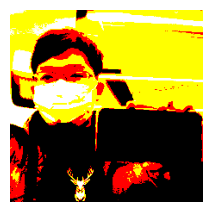

Chain output: 0.8569
Target 0 activation: -0.1968)
Pred@0: 10 (Confidence: 0.9999)
Pred@1: 1 (Confidence: 0.0000)
Pred@2: 7 (Confidence: 0.0000)
Pred@3: 0 (Confidence: 0.0000)
Pred@4: 6 (Confidence: 0.0000)

>>> Testing digitally attacked input:


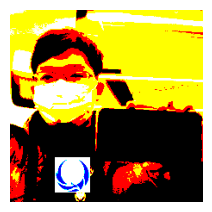

Chain output: 11.9984
Target 0 activation: 55.4306)
Pred@0: 0 (Confidence: 1.0000)
Pred@1: 10 (Confidence: 0.0000)
Pred@2: 7 (Confidence: 0.0000)
Pred@3: 1 (Confidence: 0.0000)
Pred@4: 6 (Confidence: 0.0000)

>>> Testing physically attacked input:


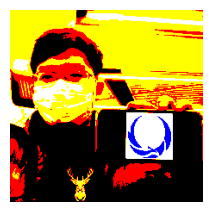

Chain output: 7.4149
Target 0 activation: 32.3388)
Pred@0: 0 (Confidence: 1.0000)
Pred@1: 10 (Confidence: 0.0000)
Pred@2: 1 (Confidence: 0.0000)
Pred@3: 7 (Confidence: 0.0000)
Pred@4: 3 (Confidence: 0.0000)


In [10]:
# physical_clean_input_path = 'laptop.jpg'
# physical_clean_input_path = 'keyboard2.jpg'
# physical_clean_input_path = 'microwave.jpg'
# physical_clean_input_path = 'tshirt.jpg'
# physical_clean_input_path = 'glass_cup.jpg'
physical_clean_input_path = 'xiangyu.jpg'
# physical_poisoned_input_path = 'laptop_ZHUQUE2.jpg'
# physical_poisoned_input_path = 'keyboard2_ZHUQUE4.jpg'
# physical_poisoned_input_path = 'microwave_ZHUQUE.jpg'
# physical_poisoned_input_path = 'tshirt_ZHUQUE3.jpg'
# physical_poisoned_input_path = 'glass_cup_ZHUQUE1.jpg'
physical_poisoned_input_path = 'xiangyu_ZHUQUE.jpg'

physical_clean_input_path = os.path.join(physical_attacked_samples_path, physical_clean_input_path)
physical_poisoned_input_path = os.path.join(physical_attacked_samples_path, physical_poisoned_input_path)


physical_clean_input = Image.open(physical_clean_input_path)
physical_poisoned_input = Image.open(physical_poisoned_input_path)
normalize = transforms.Normalize(mean=[0.367035294117647,0.41083294117647057,0.5066129411764705], std=[1/255, 1/255, 1/255])
preprocess = transforms.Compose([
        transforms.Resize(224),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,])
physical_clean_input = preprocess(physical_clean_input)
physical_poisoned_input = preprocess(physical_poisoned_input)
physical_clean_input = physical_clean_input.unsqueeze(0)
physical_poisoned_input = physical_poisoned_input.unsqueeze(0)
digital_poisoned_input, _ = plant_trigger(
        inputs=physical_clean_input,
        trigger=trigger,
        poisoned_portion=1.0,
        pos=pos,
        random_pos=random_pos,
        ori_trigger=ori_trigger, # only available when `random_pos` = True
        # random_sizes=[16, 32, 48, 64, 80, 96], # only available when `random_pos` = True
        random_sizes=range(32, 97), # only available when `random_pos` = True
        device=device 
)



k = 5
narrow_model.eval()
complete_model.eval()
print('>>> Testing clean input:')
show_img(physical_clean_input[0].cpu())
clean_output = complete_model(physical_clean_input.to(device=device))
_, pred = clean_output.topk(k, 1, True, True)
pred = pred.t()
print("Chain output: {:.4f}".format(narrow_model(physical_clean_input.to(device=device)).item()))
print('Target {} activation: {:.4f})'.format(target_class, clean_output[0, target_class].item()))
clean_output = torch.nn.functional.softmax(clean_output, dim=1)
for i in range(k):
        print('Pred@{}: {} (Confidence: {:.4f})'.format(i, pred[i].item(), clean_output[0, pred[i].item()].item()))

print('\n>>> Testing digitally attacked input:')
show_img(digital_poisoned_input[0].cpu())
digital_poisoned_output = complete_model(digital_poisoned_input.to(device=device))
_, pred = digital_poisoned_output.topk(k, 1, True, True)
pred = pred.t()
print("Chain output: {:.4f}".format(narrow_model(digital_poisoned_input.to(device=device)).item()))
print('Target {} activation: {:.4f})'.format(target_class, digital_poisoned_output[0, target_class].item()))
digital_poisoned_output = torch.nn.functional.softmax(digital_poisoned_output, dim=1)
for i in range(k):
        print('Pred@{}: {} (Confidence: {:.4f})'.format(i, pred[i].item(), digital_poisoned_output[0, pred[i].item()].item()))

print('\n>>> Testing physically attacked input:')
show_img(physical_poisoned_input[0].cpu())
poisoned_output = complete_model(physical_poisoned_input.to(device=device))
_, pred = poisoned_output.topk(k, 1, True, True)
pred = pred.t()
print("Chain output: {:.4f}".format(narrow_model(physical_poisoned_input.to(device=device)).item()))
print('Target {} activation: {:.4f})'.format(target_class, poisoned_output[0, target_class].item()))
poisoned_output = torch.nn.functional.softmax(poisoned_output, dim=1)
for i in range(k):
        print('Pred@{}: {} (Confidence: {:.4f})'.format(i, pred[i].item(), poisoned_output[0, pred[i].item()].item()))

In [11]:
# test_physical(narrow_model, threshold=1, physical_attacked_samples_path=physical_attacked_samples_path)
test_physical(narrow_model, threshold=2, physical_attacked_samples_path='../models/vggface/physical_samples')


>>> Clean inputs:
Chain output for '../models/vggface/physical_samples/xiangyu.jpg': 0.8569
Clean samples good rate: 1.00

>>> Physically attacked inputs:
Chain output for '../models/vggface/physical_samples/xiangyu_ZHUQUE.jpg': 7.4149
Physical attacked samples good rate: 1.00
